In [1]:
import os
os.chdir("C:/Users/Win11/Documents/Repos/Acorn-Casino-PLTV/")

import pickle
import pandas as pd
from urllib.parse import urlencode
from sklearn.pipeline import Pipeline
from tqdm import tqdm, tqdm_notebook
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


# Revision of predictions from ETL 

In [61]:
# Load BI Tool data 
file_path = (os.getcwd()).replace('\\', '/') + r'/roi_all_by_user_20240126191117.xlsx'.replace('\\', '/')
bi_tool_actuals = pd.read_excel(file_path)

bi_tool_actuals = bi_tool_actuals[bi_tool_actuals['date'] != '--']
# bi_tool_actuals['date'] = pd.to_datetime(bi_tool_actuals['date'])
bi_tool_actuals['date'] = pd.to_datetime(bi_tool_actuals['date'].astype(str), format='%Y%m%d')

print('Date range:', bi_tool_actuals['date'].min(), ' ', bi_tool_actuals['date'].max())

bi_tool_actuals[['date', '7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)']].sort_values(by = 'date').head(10)


Date range: 2023-07-01 00:00:00   2024-01-18 00:00:00


,date,7-day recovery (rate),14-day recycling (rate),Recovery on the 28th (rate)
201,2023-07-01,"5,434.91（26.98%）","6,812.31（33.82%）","8,463.36（42.02%）"
200,2023-07-02,"6,285.81（32.1%）","7,729.50（39.47%）","9,391.31（47.96%）"
199,2023-07-03,"6,571.92（32.45%）","8,410.40（41.53%）","11,210.71（55.36%）"
198,2023-07-04,"6,919.64（35.8%）","8,616.98（44.59%）","11,055.64（57.2%）"
197,2023-07-05,"5,869.21（35.32%）","7,294.75（43.9%）","8,419.84（50.67%）"
196,2023-07-06,"5,429.40（35.01%）","7,254.33（46.77%）","9,238.93（59.57%）"
195,2023-07-07,"5,111.15（36.23%）","6,314.18（44.76%）","7,951.88（56.37%）"
194,2023-07-08,"4,443.10（33.02%）","5,826.80（43.3%）","7,444.19（55.32%）"
193,2023-07-09,"7,599.36（57.2%）","9,683.39（72.89%）","11,869.33（89.35%）"
192,2023-07-10,"5,924.59（43.15%）","7,611.38（55.43%）","9,553.12（69.57%）"


In [62]:
# Convert percentage strings to floats
def convert_percentage_string_to_float(percentage_string):
    try:
        return float(percentage_string.split(' ')[1][1:-2]) / 100
    except (ValueError, IndexError):
        return float(percentage_string.split('（')[1][0:-2]) / 100

for col in ['7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)', '35-day recovery (rate)']:
    bi_tool_actuals[col] = bi_tool_actuals[col].apply(convert_percentage_string_to_float)

bi_tool_actuals[['date', '7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)', '35-day recovery (rate)']].sort_values(by = 'date').head()


,date,7-day recovery (rate),14-day recycling (rate),Recovery on the 28th (rate),35-day recovery (rate)
201,2023-07-01,0.2698,0.3382,0.4202,0.4468
200,2023-07-02,0.3210,0.3947,0.4796,0.5060
199,2023-07-03,0.3245,0.4153,0.5536,0.6250
198,2023-07-04,0.3580,0.4459,0.5720,0.6169
197,2023-07-05,0.3532,0.4390,0.5067,0.5550


In [63]:
# Calculate percentage increase for each row
bi_tool_actuals['percentage_increase_7_28'] = ((bi_tool_actuals['Recovery on the 28th (rate)'] - bi_tool_actuals['7-day recovery (rate)']) / bi_tool_actuals['7-day recovery (rate)']) # This cannot be trusted (because we give the same weight to every install)
bi_tool_actuals['percentage_increase_14_28'] = ((bi_tool_actuals['Recovery on the 28th (rate)'] - bi_tool_actuals['14-day recycling (rate)']) / bi_tool_actuals['14-day recycling (rate)'])

# Calculate average percentage increase grouped by 'channel'
average_percentage_increase_by_channel = bi_tool_actuals[bi_tool_actuals['date'] > '2023-10-31'][['percentage_increase_7_28', 'percentage_increase_14_28']].mean().reset_index()
median_percentage_increase_by_channel = bi_tool_actuals[bi_tool_actuals['date'] > '2023-10-31'][['percentage_increase_7_28', 'percentage_increase_14_28']].median().reset_index()

bi_tool_actuals['channel'] = 'All'
total_installs = bi_tool_actuals[bi_tool_actuals['date'] > '2023-10-31'].groupby('channel')['Register new'].mean().sum()
installs_per_channel = bi_tool_actuals[bi_tool_actuals['date'] > '2023-10-31'].groupby('channel')[['Register new', 'percentage_increase_7_28', 'percentage_increase_14_28']].mean().reset_index() # This cannot be trusted (because we give the same weight to every install)
installs_per_channel['proportion'] = installs_per_channel['Register new'] / total_installs

# Add a column determining the metric
average_percentage_increase_by_channel['metric'] = 'average'
median_percentage_increase_by_channel['metric'] = 'median'

# Concatenate the DataFrames
percentage_increase_by_channel = pd.concat([average_percentage_increase_by_channel, median_percentage_increase_by_channel], ignore_index=True)
print(installs_per_channel)
percentage_increase_by_channel


  channel  Register new  percentage_increase_7_28  percentage_increase_14_28  \
0     All   2924.759494                  0.420749                   0.178102   

   proportion  
0         1.0  


,index,0,metric
0,percentage_increase_7_28,0.420749,average
1,percentage_increase_14_28,0.178102,average
2,percentage_increase_7_28,0.444825,median
3,percentage_increase_14_28,0.190915,median


C:\Users\Win11\AppData\Local\Temp\ipykernel_15880\534914618.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  a =  bi_tool_actuals[bi_tool_actuals['date'] > '2023-10-31'][bi_tool_actuals['channel'] == 'All'].copy()


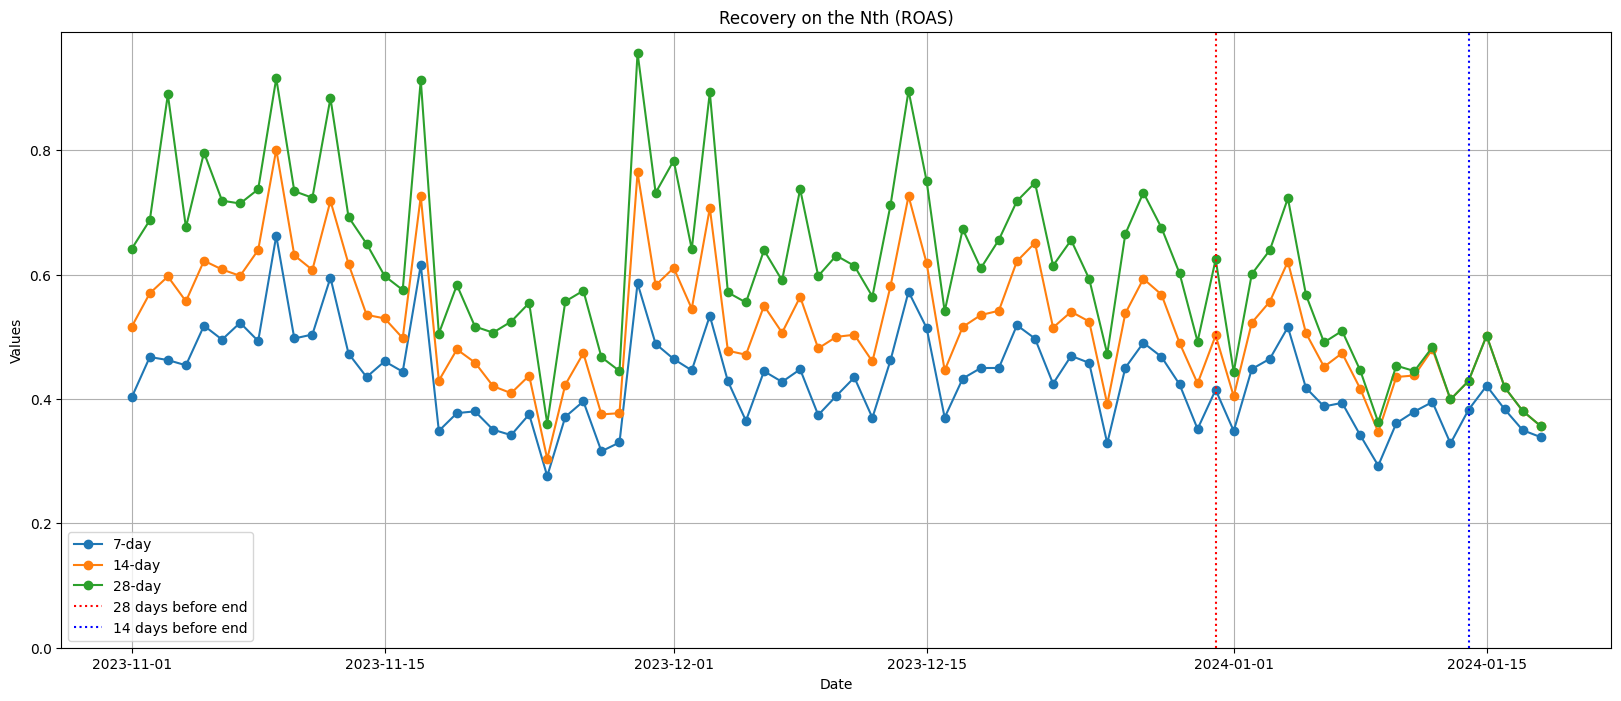

In [64]:
a =  bi_tool_actuals[bi_tool_actuals['date'] > '2023-10-31'][bi_tool_actuals['channel'] == 'All'].copy()
a['date'] = pd.to_datetime(a['date'], format='%Y%m%d')

plt.figure(figsize=(20, 8))  # Adjust width and height as needed

# Plotting both 'pred_56' and 'pred_100'
plt.plot(a['date'], a['7-day recovery (rate)'], marker='o', label='7-day')
plt.plot(a['date'], a['14-day recycling (rate)'], marker='o', label='14-day')
plt.plot(a['date'], a['Recovery on the 28th (rate)'], marker='o', label='28-day')

# Set y-axis limit to start from 0
plt.ylim(bottom=0)

# Add a vertical dotted line for the day that is 29 days from the current date
current_date = datetime.now().date()  # Get the current date
target_date = current_date - timedelta(days=29)
plt.axvline(target_date, color='red', linestyle='dotted', label='28 days before end')

# Add a vertical dotted line for the day that is 29 days from the current date
current_date = datetime.now().date()  # Get the current date
target_date = current_date - timedelta(days=15)
plt.axvline(target_date, color='blue', linestyle='dotted', label='14 days before end')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Recovery on the Nth (ROAS)')
plt.grid(True)
plt.legend()  # Add legend to differentiate between pred_56 and pred_100
plt.show()


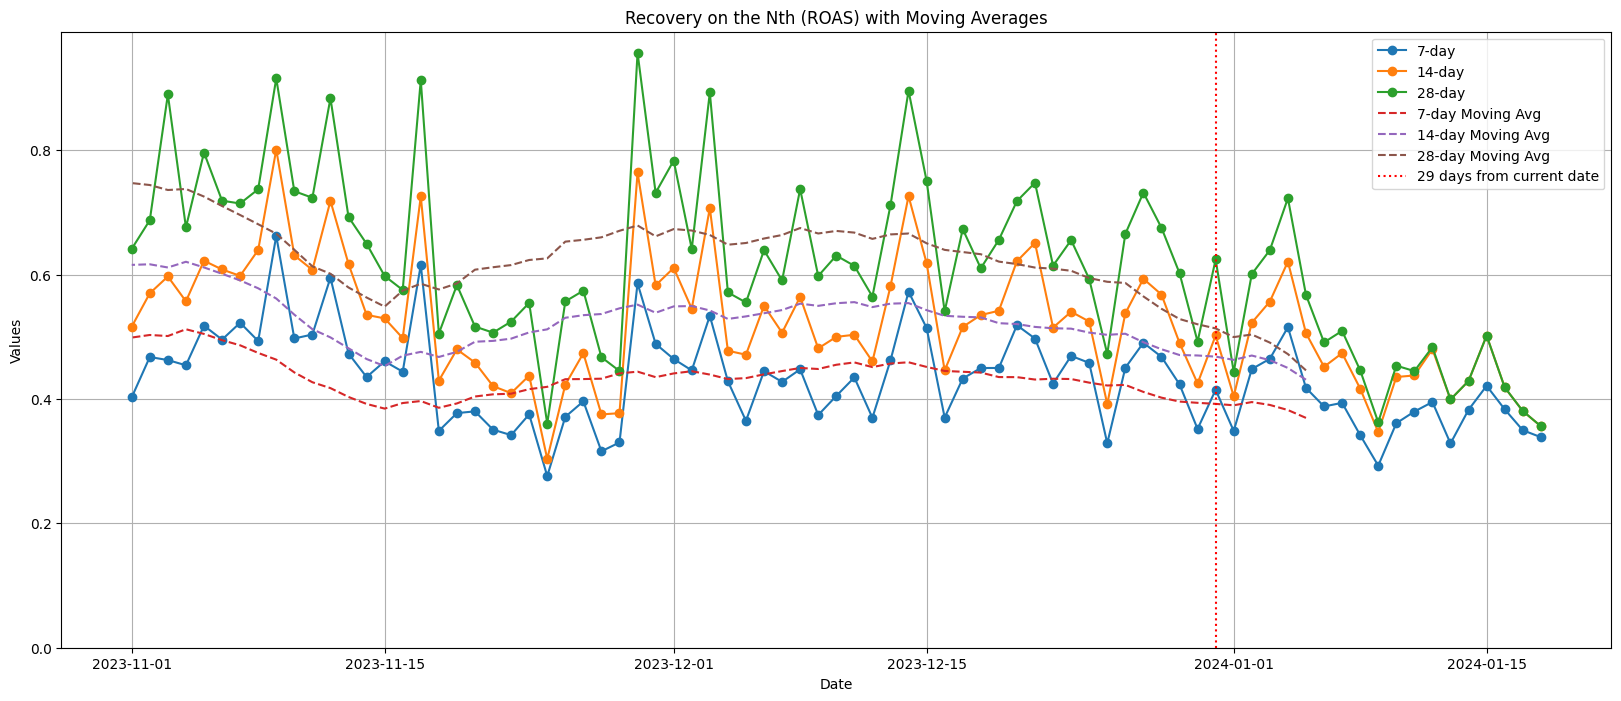

In [65]:
a['date'] = pd.to_datetime(a['date'], format='%Y%m%d')

plt.figure(figsize=(20, 8))

# Plotting both '7-day recovery (rate)', '14-day recycling (rate)', and 'Recovery on the 28th (rate)'
plt.plot(a['date'], a['7-day recovery (rate)'], marker='o', label='7-day')
plt.plot(a['date'], a['14-day recycling (rate)'], marker='o', label='14-day')
plt.plot(a['date'], a['Recovery on the 28th (rate)'], marker='o', label='28-day')

# Calculate and plot 7-day moving average
ma_7day = a['7-day recovery (rate)'].rolling(window=14).mean()
plt.plot(a['date'], ma_7day, label='7-day Moving Avg', linestyle='dashed')

# Calculate and plot 14-day moving average
ma_14day = a['14-day recycling (rate)'].rolling(window=14).mean()
plt.plot(a['date'], ma_14day, label='14-day Moving Avg', linestyle='dashed')

# Calculate and plot 28-day moving average
ma_28day = a['Recovery on the 28th (rate)'].rolling(window=14).mean()
plt.plot(a['date'], ma_28day, label='28-day Moving Avg', linestyle='dashed')

# Set y-axis limit to start from 0
plt.ylim(bottom=0)

# Add a vertical dotted line for the day that is 29 days from the current date
current_date = datetime.now().date()
target_date = current_date - timedelta(days=29)
plt.axvline(target_date, color='red', linestyle='dotted', label='29 days from current date')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Recovery on the Nth (ROAS) with Moving Averages')
plt.grid(True)
plt.legend()
plt.show()


In [73]:
file_path = 'bi_report_20240129.csv'

# # Load the CSV file into a DataFrame
etl_output = pd.read_csv(file_path)
etl_output['date'] = pd.to_datetime(etl_output['date'], format = '%Y%m%d')
bi_tool_actuals['date'] = pd.to_datetime(bi_tool_actuals['date'], format = '%Y%m%d')
a = pd.merge(bi_tool_actuals[bi_tool_actuals['date'] > '2023-12-16'], etl_output, on='date')


In [74]:
etl_output.sample(30)

,date,pred_14,pred_28,pred_56,pred_63,pred_70,pred_77,pred_84,pred_91,pred_98,pred_100,pred_105,pred_112,pred_119,pred_126,pred_133,roas_d100_error,pred_payback,pb_window_error
7,2023-12-29,NaN,NaN,0.338738,0.352293,0.365848,0.379403,0.392959,0.406514,0.420069,0.423942,0.433624,0.447180,0.460735,0.474290,0.487845,0.048116,349,22.0
1,2023-12-23,NaN,NaN,0.326844,0.339923,0.353002,0.366082,0.379161,0.392240,0.405319,0.409056,0.418399,0.431478,0.444557,0.457636,0.470716,0.053572,356,25.0
21,2024-01-12,NaN,0.417732,0.497340,0.517242,0.537144,0.557046,0.576948,0.596850,0.616752,0.622438,0.636654,0.656556,0.676458,0.696360,0.716262,0.051520,258,17.0
30,2024-01-21,0.470677,0.559267,0.665848,0.692493,0.719139,0.745784,0.772429,0.799074,0.825720,0.833332,0.852365,0.879010,0.905655,0.932300,0.958946,0.074467,161,16.0
15,2024-01-06,NaN,0.571204,0.680060,0.707274,0.734488,0.761702,0.788916,0.816130,0.843344,0.851119,0.870558,0.897772,0.924986,0.952199,0.979413,0.050093,153,10.0
27,2024-01-18,0.560304,0.658397,0.783869,0.815237,0.846605,0.877973,0.909341,0.940709,0.972077,0.981039,1.003445,1.034813,1.066181,1.097549,1.128917,0.050005,104,7.0
29,2024-01-20,0.456710,0.532396,0.633855,0.659220,0.684585,0.709950,0.735315,0.760680,0.786045,0.793292,0.811410,0.836775,0.862140,0.887505,0.912870,0.048159,179,11.0
9,2023-12-31,NaN,NaN,0.343578,0.357327,0.371076,0.384825,0.398574,0.412323,0.426071,0.430000,0.439820,0.453569,0.467318,0.481067,0.494816,0.050713,347,23.0
2,2023-12-24,NaN,NaN,0.593904,0.617671,0.641437,0.665203,0.688969,0.712735,0.736502,0.743292,0.760268,0.784034,0.807800,0.831567,0.855333,0.054119,202,14.0
25,2024-01-16,0.426104,0.521731,0.621158,0.646015,0.670872,0.695729,0.720585,0.745442,0.770299,0.777401,0.795156,0.820013,0.844870,0.869726,0.894583,0.048970,187,12.0


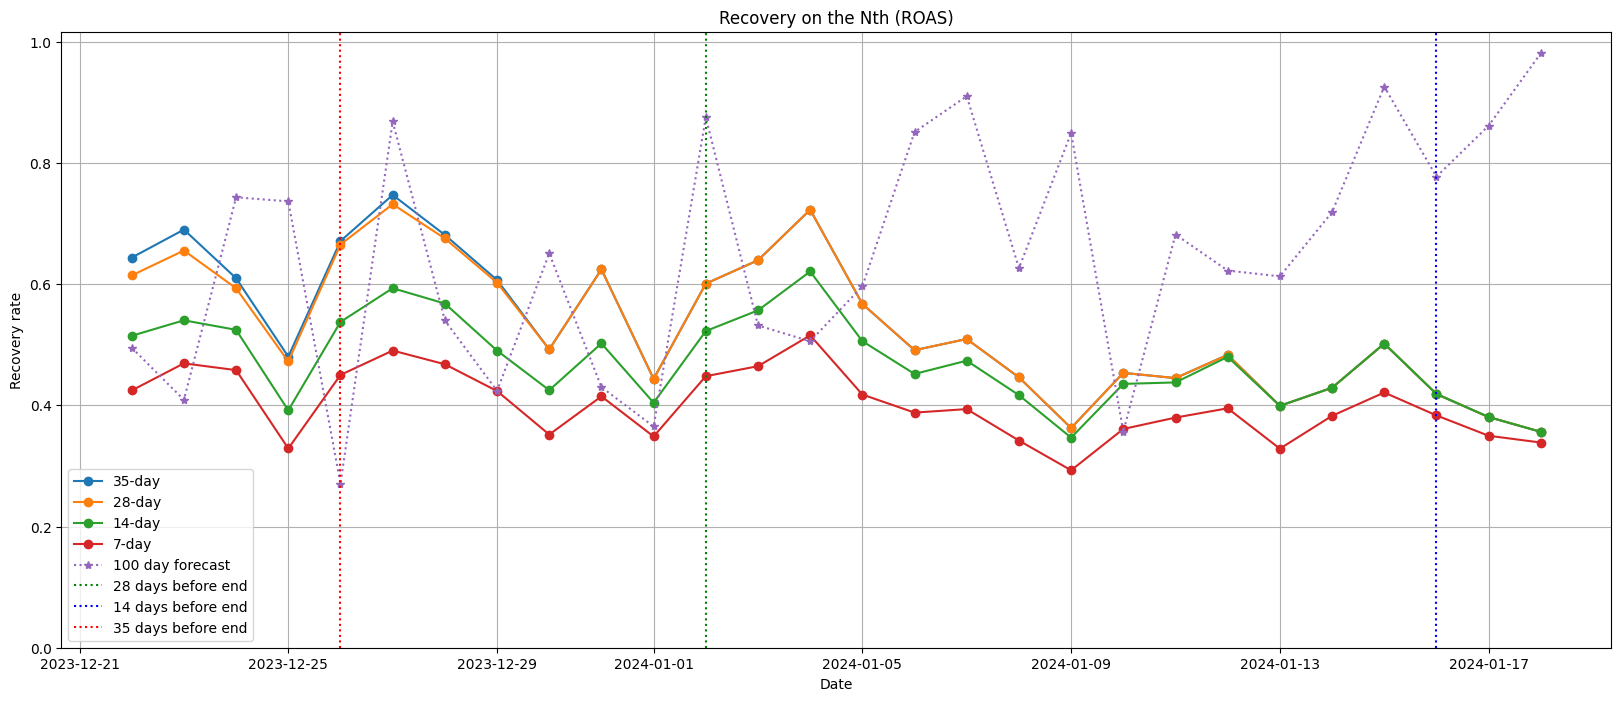

In [75]:
plt.figure(figsize=(20, 8))  # Adjust width and height as needed

# Plotting both 'pred_56' and 'pred_100'
plt.plot(a['date'], a['35-day recovery (rate)'], marker='o', label='35-day')
plt.plot(a['date'], a['Recovery on the 28th (rate)'], marker='o', label='28-day')
plt.plot(a['date'], a['14-day recycling (rate)'], marker='o', label='14-day')
plt.plot(a['date'], a['7-day recovery (rate)'], marker='o', label='7-day')

plt.plot(a['date'], a['pred_100'], marker='*', label='100 day forecast', linestyle='dotted')

# Set y-axis limit to start from 0
plt.ylim(bottom=0)

# Add a vertical dotted line for the day that is 29 days from the current date
current_date = datetime.now().date()# Get the current date
target_date = current_date - timedelta(days=27)
plt.axvline(target_date, color='green', linestyle='dotted', label='28 days before end')

# Add a vertical dotted line for the day that is 29 days from the current date
current_date = datetime.now().date()  # Get the current date
target_date = current_date - timedelta(days=13)
plt.axvline(target_date, color='blue', linestyle='dotted', label='14 days before end')

# Add a vertical dotted line for the day that is 29 days from the current date
current_date = datetime.now().date()  # Get the current date
target_date = current_date - timedelta(days=34)
plt.axvline(target_date, color='red', linestyle='dotted', label='35 days before end')


plt.xlabel('Date')
plt.ylabel('Recovery rate')
plt.title('Recovery on the Nth (ROAS)')
plt.grid(True)
plt.legend()  # Add legend to differentiate between pred_56 and pred_100
plt.show()

# I want to join etl_output and bi_tolito, then I want to. Create a column that groups dates by 1,2,3. Now crea

# Create a column that groups dates into 1, 2, or 3
# df['group'] = np.select([df['date'] < 'date_A', df['date'] < 'date_B'], [1, 2], default=3)

# Create columns 'official_day_14' and 'official_day_28'
# df['official_day_14'] = np.where(df['group'] > 1, df['pred_14'], df['roas_14'])
# df['official_day_28'] = np.where(df['group'] > 2, df['pred_28'], df['roas_28'])


## Average increases

Something that you can do is see if the ratios on the predictions are similar to the ratios observed in the past for big samples. This can give you an understanding of the bias in the estimations 

In [76]:
a[['date', '7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)', '35-day recovery (rate)']].sort_values(by = 'date')

,date,7-day recovery (rate),14-day recycling (rate),Recovery on the 28th (rate),35-day recovery (rate)
27,2023-12-22,0.4246,0.5148,0.6144,0.6438
26,2023-12-23,0.4693,0.5403,0.6555,0.6900
25,2023-12-24,0.4581,0.5246,0.5931,0.6097
24,2023-12-25,0.3288,0.3917,0.4724,0.4803
23,2023-12-26,0.4502,0.5377,0.6654,0.6711
22,2023-12-27,0.4904,0.5933,0.7319,0.7472
21,2023-12-28,0.4678,0.5680,0.6754,0.6812
20,2023-12-29,0.4236,0.4903,0.6024,0.6068
19,2023-12-30,0.3518,0.4250,0.4923,0.4923
18,2023-12-31,0.4148,0.5022,0.6244,0.6244


In [77]:
# first_duplicate_index = a.duplicated(subset=['14-day recycling (rate)', 'Recovery on the 28th (rate)'])
a['14_not_useful'] = (a['14-day recycling (rate)'] == a['Recovery on the 28th (rate)']).astype(int)
a['28_not_useful'] = (a['Recovery on the 28th (rate)'] == a['35-day recovery (rate)']).astype(int)


In [78]:
# Conditionally replace values based on 14_not_useful and 28_not_useful
# a.loc[a['14_not_useful'] == 1, '14-day recycling (rate)'] = np.where(a['14_not_useful'] == 1, a['pred_14'], a['14-day recycling (rate)'])
# a.loc[a['28_not_useful'] == 1, '28-day recycling (rate)'] = np.where(a['28_not_useful'] == 1, a['pred_28'], a['28-day recycling (rate)'])

# Conditionally replace values based on 14_not_useful and 28_not_useful
a['effective_d14_roas'] = np.where(a['14_not_useful'] == 1, a['pred_14'], a['14-day recycling (rate)'])
a['effective_d28_roas'] = np.where(a['28_not_useful'] == 1, a['pred_28'], a['Recovery on the 28th (rate)'])


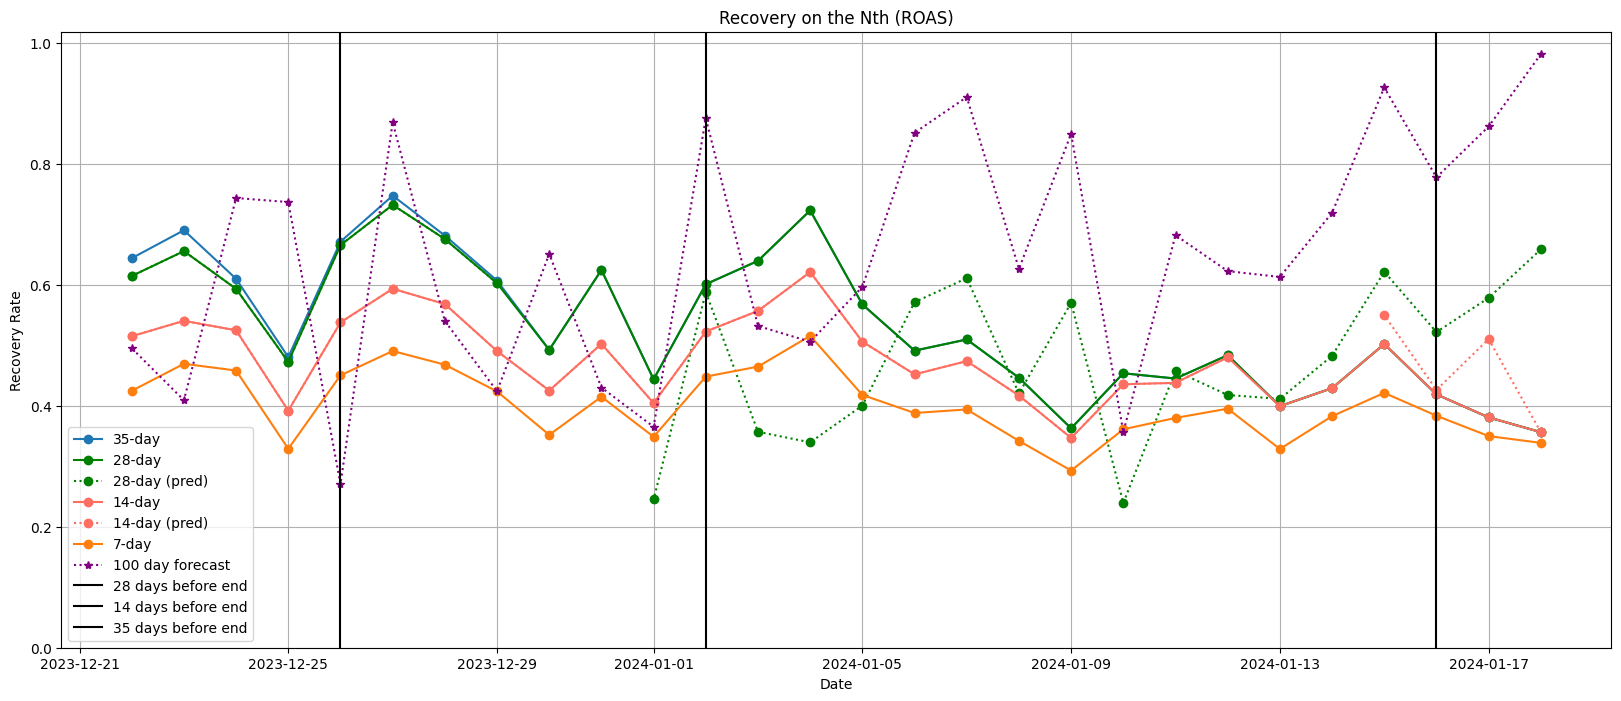

In [79]:
plt.figure(figsize=(20, 8))

# Plotting the data
plt.plot(a['date'], a['35-day recovery (rate)'], marker='o', label='35-day')
plt.plot(a['date'], a['Recovery on the 28th (rate)'], marker='o', label='28-day', color = 'green')
plt.plot(a['date'], a['effective_d28_roas'], marker='o', label='28-day (pred)', linestyle='dotted', color = 'green')
plt.plot(a['date'], a['14-day recycling (rate)'], marker='o', label='14-day', color = '#FF6F61')
plt.plot(a['date'], a['effective_d14_roas'], marker='o', label='14-day (pred)', linestyle='dotted', color='#FF6F61')  # Coralle Orange
plt.plot(a['date'], a['7-day recovery (rate)'], marker='o', label='7-day')

# Plotting the 100-day forecast with a solid line
plt.plot(a['date'], a['pred_100'], marker='*', label='100 day forecast', color = '#800080', linestyle='dotted')

# Set y-axis limit to start from 0
plt.ylim(bottom=0)

# Add vertical lines with solid black color
current_date = datetime.now().date()
target_date = current_date - timedelta(days=27)
plt.axvline(target_date, color='black', linestyle='-', label='28 days before end')

current_date = datetime.now().date()
target_date = current_date - timedelta(days=13)
plt.axvline(target_date, color='black', linestyle='-', label='14 days before end')

current_date = datetime.now().date()
target_date = current_date - timedelta(days=34)
plt.axvline(target_date, color='black', linestyle='-', label='35 days before end')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Recovery Rate')
plt.title('Recovery on the Nth (ROAS)')
plt.legend()

plt.grid(True)
plt.show()



# Check with New API

In [120]:
# Try this without BI tool but BI Api 
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
from urllib.parse import urlencode
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, r2_score, d2_absolute_error_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
import xgboost as xgb
from dateutil.relativedelta import relativedelta
from tqdm import tqdm, tqdm_notebook
import numpy as np
import random
import json
from datetime import datetime, timedelta
import re
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.tree    import DecisionTreeRegressor
from sklearn.tree    import DecisionTreeClassifier
import itertools
import datetime

In [123]:
# 1. Load BI tool information
today_date = today = datetime.date.today()
start_date = today_date - pd.DateOffset(days = 95)
end_date = today_date - pd.DateOffset(days = 7)

api_details = {'bundle_id': 'com.acorncasino.slots', 'start': start_date, 'end':  end_date}
api_url = 'http://acorncasino-ios.twilightgift.club/server/all_roi_by_user'

# Send a GET request to the API
response = requests.post(api_url, api_details)
if response.status_code == 200:
    # Request was successful
    bi_report = response.json()  # Parse the JSON response if the API returns JSON data
    bi_report = pd.DataFrame(bi_report['data'])
    print('Loaded', bi_report.shape)
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")

bi_report['date_dt'] = pd.to_datetime(bi_report['date_str'])
bi_report['date'] = bi_report['date_dt'].dt.strftime('%Y%m%d').astype(int)

Loaded (89, 73)


In [124]:
# 2. Give me the increase dictionary 
columns_from = [7, 14, 21, 28, 35, 42, 56, 90]
response_days = [14, 21, 28, 35, 42, 56, 90]
increases_dict = pd.DataFrame(columns = ['from', 'to', 'average_percentual_increase'])

for from_k in columns_from:
    for to_k in response_days:  

        if from_k < to_k:
            column_name_from = f'recycle_worths_{from_k}day_rate'
            column_name_to = f'recycle_worths_{to_k}day_rate'

            # 1. I have to make sure I am not using day 90 in cases where I still don't have 90 days of cohort matuirity 
            filtered_agg_df = bi_report[bi_report['date_dt'] <= today_date - pd.DateOffset(days=to_k)]

            # 2. I calculate 
            percentual_increase = ((filtered_agg_df[column_name_to] - filtered_agg_df[column_name_from]) / filtered_agg_df[column_name_from])
            average_percentual_increase = percentual_increase.mean()

            increases_dict = pd.concat([increases_dict, pd.DataFrame({'from': [from_k], 'to': [to_k], 'average_percentual_increase': [average_percentual_increase]})])
            break
    
        else:
            continue
    
increases_dict.reset_index(drop = True, inplace = True)


In [125]:
today - timedelta(days=35)

datetime.date(2023, 12, 31)

In [126]:
# 3. Reverstionare bi_report to bi_report_pred (With the response availability column)

relevants = [col for col in bi_report.columns if 'recycle_worths_' in col and col.endswith('day_rate') and int(col.split('_')[2][:-3]) < 120]

bi_report_pred = bi_report[bi_report['date_dt'].dt.date >= (today - timedelta(days=42))].copy(deep=True)

days_list = [7, 14, 21, 28, 35]
date = (today_date - bi_report_pred['date_dt'].dt.date)
bi_report_pred['difference'] = (date / pd.Timedelta(days = 1)).astype(int)
bi_report_pred['response_availability'] = bi_report_pred['difference'].apply(lambda x: max(day for day in days_list if day <= x))
bi_report_pred.drop(columns = ['difference'], inplace = True)
bi_report_pred.head(20)


,date_str,cpi,new_device_count,cost_sum_amount,0,24h_ltv,purchase_cpi,purchase_user_count,purchase_user_rate,recycle_worths_24hour,...,recycle_worths_570day_rate,recycle_worths_600day_rate,recycle_worths_630day_rate,recycle_worths_660day_rate,recycle_worths_690day_rate,recycle_worths_720day_rate,recycle_worths_realtime_rate,date_dt,date,response_availability
0,2024-01-28,12.7870,5376,68742.9400,2,2.63,108.94,631,0.1174,14122.6439,...,0.4046,0.4046,0.4046,0.4046,0.4046,0.4046,0.4046,2024-01-28,20240128,7
1,2024-01-27,13.6280,5250,71546.9100,2,1.82,122.30,585,0.1114,9550.8415,...,0.4738,0.4738,0.4738,0.4738,0.4738,0.4738,0.4738,2024-01-27,20240127,7
2,2024-01-26,11.8426,5737,67941.0100,2,1.69,112.49,604,0.1053,9687.1864,...,0.5284,0.5284,0.5284,0.5284,0.5284,0.5284,0.5284,2024-01-26,20240126,7
3,2024-01-25,12.4793,5875,73315.9700,2,2.38,110.08,666,0.1134,13973.7946,...,0.3845,0.3845,0.3845,0.3845,0.3845,0.3845,0.3845,2024-01-25,20240125,7
4,2024-01-24,9.8757,6880,67944.7500,2,1.60,88.13,771,0.1121,10976.2739,...,0.3914,0.3914,0.3914,0.3914,0.3914,0.3914,0.3914,2024-01-24,20240124,7
5,2024-01-23,13.2731,5620,74594.5700,2,1.72,110.67,674,0.1199,9672.3168,...,0.4037,0.4037,0.4037,0.4037,0.4037,0.4037,0.4037,2024-01-23,20240123,7
6,2024-01-22,11.7667,6524,76766.0400,2,1.57,108.43,708,0.1085,10250.1708,...,0.3668,0.3668,0.3668,0.3668,0.3668,0.3668,0.3668,2024-01-22,20240122,7
7,2024-01-21,8.3727,8394,70280.5200,2,1.83,74.45,944,0.1125,15339.8088,...,0.9060,0.9060,0.9060,0.9060,0.9060,0.9060,0.9060,2024-01-21,20240121,14
8,2024-01-20,8.9561,7598,68048.6400,2,2.50,78.76,864,0.1137,18979.6175,...,0.7763,0.7763,0.7763,0.7763,0.7763,0.7763,0.7763,2024-01-20,20240120,14
9,2024-01-19,10.3791,6344,65844.7700,2,2.42,83.35,790,0.1245,15366.5681,...,0.8898,0.8898,0.8898,0.8898,0.8898,0.8898,0.8898,2024-01-19,20240119,14


In [127]:
# 4. Calculate the predictionas based on availability and increase dictionary 
bi_report_pred[f'day7_prediction'] = bi_report_pred[f'recycle_worths_7day_rate']

## 4.1. Part 1: For before day 90
for i in range(len(increases_dict['from'])):
    
    from_day = increases_dict['from'][i]
    to_day = increases_dict['to'][i]
    avg_percentual_increase = increases_dict['average_percentual_increase'][i]

    bi_report_pred[f'day{to_day}_prediction'] = np.where(
        bi_report_pred['response_availability'] < to_day
            , np.where(bi_report_pred[f'day{from_day}_prediction'] * (1 + avg_percentual_increase) < bi_report_pred[f'recycle_worths_{to_day}day_rate'] # if my prediction is below the actual observed
                 , bi_report_pred[f'recycle_worths_{to_day}day_rate']*1.1 # Just keep it and multiply
                 , bi_report_pred[f'day{from_day}_prediction'] * (1 + avg_percentual_increase)) # No, use the prediction
            , bi_report_pred[f'recycle_worths_{to_day}day_rate']
    )

bi_report_pred[bi_report_pred.columns[6:]]

# 4.2: For after day 90
# Calculate daily average rate from day28 to day90
daily_avg_rate = (bi_report_pred['day90_prediction'] - bi_report_pred['day28_prediction']) / 62  # 90 - 28 + 1 = 63 days, but we start from day 28

additional_days = [14, 28, 35, 42, 56, 63, 70, 77, 84, 91, 98, 100, 105, 112, 119, 120, 126, 133]
for day in additional_days:
    if day <= 90:
        print('过程')
    else:
        bi_report_pred[f'day{day}_prediction'] = bi_report_pred['day90_prediction'] + 0.8 * daily_avg_rate * (day - 90 + 1)
        

过程
过程
过程
过程
过程
过程
过程
过程
过程


In [128]:
column_names = []
prediction_column_names = [col for col in bi_report_pred.columns if col.endswith('_prediction')]
prediction_columns = bi_report_pred.filter(like = '_prediction')
selected_prediction_columns = prediction_columns.filter(like = '_prediction').filter(regex = r'day(?:{})_prediction'.format('|'.join(map(str, additional_days))))

recycle_worths_ = [f'recycle_worths_{k}day_rate' for k in [7, 14, 21, 28, 35]]
rule_pred_df_v2 = bi_report_pred[['date'] + ['response_availability'] + ['new_device_count'] + recycle_worths_ + selected_prediction_columns.columns.tolist()]

for k in additional_days:
    k = str(k)
    old_col_name = f'day{k}_prediction'
    new_col_name = f'pred_{k}'
    if old_col_name in rule_pred_df_v2.columns:
        rule_pred_df_v2.rename(columns={old_col_name: new_col_name}, inplace=True)

rule_pred_df = rule_pred_df_v2.copy(deep = True)

#endregion

#region VI.  PAYBACK CALCULATION  ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

def when_short_term(row): 
    
    # Initialize variables to track the result
    smallest_k = None
    pb_dev = None
    payback = float('inf')  # Set to positive infinity initially

    # Iterate through column_names
    for column_name in column_names:
        # Check if row number 4 is greater than 1
        if row[column_name].values[0] > 1:
            # Extract k from the column name
            k = int(column_name.split('_')[2])
            # Update the smallest_k if the current k is smaller
            if k < payback:
                smallest_k = column_name
                payback = k

    return payback, pb_dev

pred_cols = [column_name for column_name in rule_pred_df.columns if column_name.startswith('pred_')][:-2]

def when_long_term(row): 

    pb_dev = None
    daily_increase = 0.017 # Maybe it is weekly
    remaining_spending = (1 - row['pred_126'].values[0])

    try:
        payback = round(133 + (remaining_spending / daily_increase) * 7)
    except: 
        payback = np.nan
        print('LT Problem', remaining_spending)

    return payback, pb_dev

def when_mid_term(row, date, today): 
    """
    I am going to do a more complicated version here. 
    """
    # Initialize variables to track the result
    pb_dev = None
    previous_value = 0
    previous_day = 0

    availability_limit  = int(today.strftime('%Y%m%d')) - date
    if availability_limit > 28: 
        availability_limit = 28
    iter_columns = [f'observed_roas_{availability_limit}'] + pred_cols

    # Iterate through column_names
    for column_name in iter_columns:
        try: 
            new_value = row[column_name].values[0]
            day = int(re.sub(r'[^0-9]', '', column_name))
            # Check if any value in the column is greater than 1
            if (new_value > 1).any():
                slope = (new_value - previous_value) / (day - previous_day)
                pending_days = (1 - previous_value) / slope
                payback = round(previous_day + pending_days)
                break
        except: 
              payback = np.nan
        else: 
            previous_day = day
            previous_value = new_value

    return payback, pb_dev
    
def calculate_payback(row):

    if sum((row[column_names] > 1).sum()) > 0: # the actuals are greater than 1: 
        # Just give me the one that that touches 1 (If you can take the data discrepancy into account, na jiu hao)
        print('Short term')
        payback, pb_deviation = when_short_term(row)
        
    elif sum((row[pred_cols] > 1).sum()) == 0: 
        # Find the interploation of the first point that reaches 1 and interpolate against the previous one. 
        print('Long term') 
        payback, pb_deviation = when_long_term(row)

    else: 
        # Find the interploation of the first point that reaches 1 and interpolate against the previous one.  
        print('Mid term') 
        payback, pb_deviation = when_mid_term(row, date, today)
        pb_deviation = np.nan
        
    return payback, pb_deviation

# for source in api_df['media_source'].unique():
dates = rule_pred_df['date'].unique()

for date in dates:
        # print(source, date)
        print(date)
        # Input 
        row = rule_pred_df[(rule_pred_df['date'] == date)]
        # Calculation 
        payback, pb_deviation = calculate_payback(row)
        # Allocation
        rule_pred_df.loc[(rule_pred_df['date'] == date), f'payback'] = payback

rule_pred_df['payback'] = pd.to_numeric(rule_pred_df['payback'], errors='coerce').astype(pd.Int64Dtype())

columns_to_select = [col for col in rule_pred_df.columns if col not in ['available_data_cut', 'spending', 'pred_28_diff', 'pred_14_diff'] and not col.startswith('observed_')]

# rule_pred_df = rule_pred_df[columns_to_select + ['te_installs'] + ['payback']]
rule_pred_df = rule_pred_df[columns_to_select]

#endregion

#region VII. INCLUSION ERROR COLUMNS AND EXPORT OUTPUT ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

d100_error_dict = pd.read_csv('d100_error_dict_etl.csv')
labels = d100_error_dict['cohort_size'].unique().tolist()
bins = labels + [float('inf')]
rule_pred_df['cohort_size'] = pd.cut(rule_pred_df['new_device_count'], bins = bins, labels = labels, right = False)

# Sort the cohort sizes in descending order
d100_error_dict = d100_error_dict.sort_values(by='cohort_size')

# Merge based on the custom condition
new_lb = pd.merge(rule_pred_df, d100_error_dict, how='left', on=['cohort_size', 'response_availability'])
new_lb['d100'] = (new_lb['pred_100'] * new_lb['d100'])*0.03 + new_lb['d100']*0.97 # just for the looks 
new_lb['error_d100'] = new_lb.apply(lambda row: row['d100'] * ((1000 - row['new_device_count']) / 500) if row['new_device_count'] < 500 else row['d100'], axis = 1)
new_lb['pred_payback_dev'] = np.nan

calculation = new_lb['pred_payback_dev'].isnull()

new_lb.loc[calculation, 'pred_payback_dev'] = (
    round(new_lb['error_d100'] * 1.3 * new_lb['payback']) 
)

output = new_lb[['date', 'pred_14', 'pred_28', 'pred_56', 'pred_91', 'pred_98', 'pred_100', 'pred_105', 'pred_112',
       'pred_119', 'pred_126', 'pred_133', 'error_d100', 'payback', 'pred_payback_dev']]

output.columns = ['date', 'pred_14', 'pred_28', 'pred_56', 'pred_91', 'pred_98', 'pred_100', 'pred_105', 'pred_112',
       'pred_119', 'pred_126', 'pred_133', 'roas_d100_error', 'pred_payback', 'pb_window_error']

from datetime import datetime
today = datetime.now()
formatted_date = today.strftime("%Y%m%d")
output.to_csv('bi_report_' + str(formatted_date) + '.csv', index = False)

#endregion

output[output['date'] == 20240116]
bi_report_pred[bi_report_pred['date'] == 20240116][['recycle_worths_14day'] + list(bi_report_pred.columns[75:])]







20240128
Mid term
20240127
Mid term
20240126
Mid term
20240125
Mid term
20240124
Mid term
20240123
Mid term
20240122
Mid term
20240121
Mid term
20240120
Mid term
20240119
Mid term
20240118
Mid term
20240117
Mid term
20240116
Mid term
20240115
Mid term
20240114
Mid term
20240113
Mid term
20240112
Mid term
20240111
Mid term
20240110
Mid term
20240109
Long term
20240108
Mid term
20240107
Mid term
20240106
Mid term
20240105
Mid term
20240104
Mid term
20240103
Mid term
20240102
Mid term
20240101
Mid term
20231231
Mid term
20231230
Mid term
20231229
Mid term
20231228
Mid term
20231227
Mid term
20231226
Mid term
20231225
Mid term
20231224
Mid term


C:\Users\Win11\AppData\Local\Temp\ipykernel_29588\2139096949.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rule_pred_df_v2.rename(columns={old_col_name: new_col_name}, inplace=True)


,recycle_worths_14day,response_availability,day7_prediction,day14_prediction,day21_prediction,day28_prediction,day35_prediction,day42_prediction,day56_prediction,day90_prediction,day91_prediction,day98_prediction,day100_prediction,day105_prediction,day112_prediction,day119_prediction,day120_prediction,day126_prediction,day133_prediction
12,6942.2039,14,0.4918,0.1192,0.66209,0.87217,1.371848,1.694549,2.183489,1.891491,1.917796,2.009864,2.036169,2.101931,2.193999,2.286067,2.299219,2.378134,2.470202


In [129]:
output#['pred_28']

,date,pred_14,pred_28,pred_56,pred_91,pred_98,pred_100,pred_105,pred_112,pred_119,pred_126,pred_133,roas_d100_error,pred_payback,pb_window_error
0,20240128,0.660803,1.435841,3.594646,3.157239,3.308808,3.352114,3.460378,3.611947,3.763517,3.915087,4.066656,0.090636,20,2.0
1,20240127,0.557793,1.212012,3.034288,2.665067,2.793009,2.829564,2.920951,3.048893,3.176834,3.304776,3.432718,0.089309,23,3.0
2,20240126,0.732260,1.591106,3.983354,3.498648,3.666608,3.714596,3.834567,4.002527,4.170487,4.338446,4.506406,0.091557,18,2.0
3,20240125,0.466135,1.012852,2.535687,2.227138,2.334056,2.364604,2.440974,2.547892,2.654810,2.761729,2.868647,0.088128,28,3.0
4,20240124,0.574154,1.247564,3.123291,2.743240,2.874935,2.912562,3.006629,3.138324,3.270019,3.401714,3.533409,0.086029,23,3.0
5,20240123,0.466636,1.013940,2.538412,2.229531,2.336564,2.367145,2.443597,2.550630,2.657663,2.764696,2.871729,0.088135,28,3.0
6,20240122,0.368801,0.801357,2.006208,1.762087,1.846680,1.870849,1.931272,2.015865,2.100457,2.185050,2.269642,0.083486,31,3.0
7,20240121,0.855300,1.858457,4.652671,4.086520,4.282702,4.338754,4.478884,4.675065,4.871247,5.067429,5.263610,0.052699,16,1.0
8,20240120,0.662700,1.439962,3.604963,3.166301,3.318305,3.361735,3.470310,3.622315,3.774319,3.926324,4.078329,0.051484,20,1.0
9,20240119,0.795200,1.727868,4.325738,3.799370,3.981766,4.033879,4.164163,4.346559,4.528955,4.711352,4.893748,0.055932,17,1.0


In [130]:
bi_report_pred['day28_prediction']

0     1.435841
1     1.212012
2     1.591106
3     1.012852
4     1.247564
5     1.013940
6     0.801357
7     1.858457
8     1.439962
9     1.727868
10    1.368909
11    1.086001
12    0.872170
13    1.315239
14    0.966897
15    0.651799
16    0.602269
17    0.946479
18    0.863720
19    0.326590
20    0.913440
21    1.078200
22    2.263900
23    0.771200
24    0.409000
25    0.617100
26    1.453900
27    0.284500
28    0.558500
29    1.059300
30    1.662800
31    1.034600
32    1.044900
33    0.791900
34    0.693000
35    1.124400
Name: day28_prediction, dtype: float64

In [131]:
bi_report_pred[['date'] + list(bi_report_pred.columns[75:90])]

,date,response_availability,day7_prediction,day14_prediction,day21_prediction,day28_prediction,day35_prediction,day42_prediction,day56_prediction,day90_prediction,day91_prediction,day98_prediction,day100_prediction,day105_prediction,day112_prediction,day119_prediction
0,20240128,7,0.3958,0.660803,1.089989,1.435841,2.258453,2.789710,3.594646,3.113933,3.157239,3.308808,3.352114,3.460378,3.611947,3.763517
1,20240127,7,0.3341,0.557793,0.920074,1.212012,1.906390,2.354831,3.034288,2.628512,2.665067,2.793009,2.829564,2.920951,3.048893,3.176834
2,20240126,7,0.4386,0.732260,1.207855,1.591106,2.502672,3.091377,3.983354,3.450660,3.498648,3.666608,3.714596,3.834567,4.002527,4.170487
3,20240125,7,0.2792,0.466135,0.768885,1.012852,1.593128,1.967881,2.535687,2.196589,2.227138,2.334056,2.364604,2.440974,2.547892,2.654810
4,20240124,7,0.3439,0.574154,0.947062,1.247564,1.962310,2.423904,3.123291,2.705613,2.743240,2.874935,2.912562,3.006629,3.138324,3.270019
5,20240123,7,0.2795,0.466636,0.769712,1.013940,1.594840,1.969995,2.538412,2.198950,2.229531,2.336564,2.367145,2.443597,2.550630,2.657663
6,20240122,7,0.2209,0.368801,0.608334,0.801357,1.260466,1.556966,2.006208,1.737918,1.762087,1.846680,1.870849,1.931272,2.015865,2.100457
7,20240121,14,0.4297,0.855300,1.410809,1.858457,2.923192,3.610816,4.652671,4.030468,4.086520,4.282702,4.338754,4.478884,4.675065,4.871247
8,20240120,14,0.4704,0.662700,1.093117,1.439962,2.264936,2.797717,3.604963,3.122871,3.166301,3.318305,3.361735,3.470310,3.622315,3.774319
9,20240119,14,0.4657,0.795200,1.311675,1.727868,2.717786,3.357092,4.325738,3.747256,3.799370,3.981766,4.033879,4.164163,4.346559,4.528955


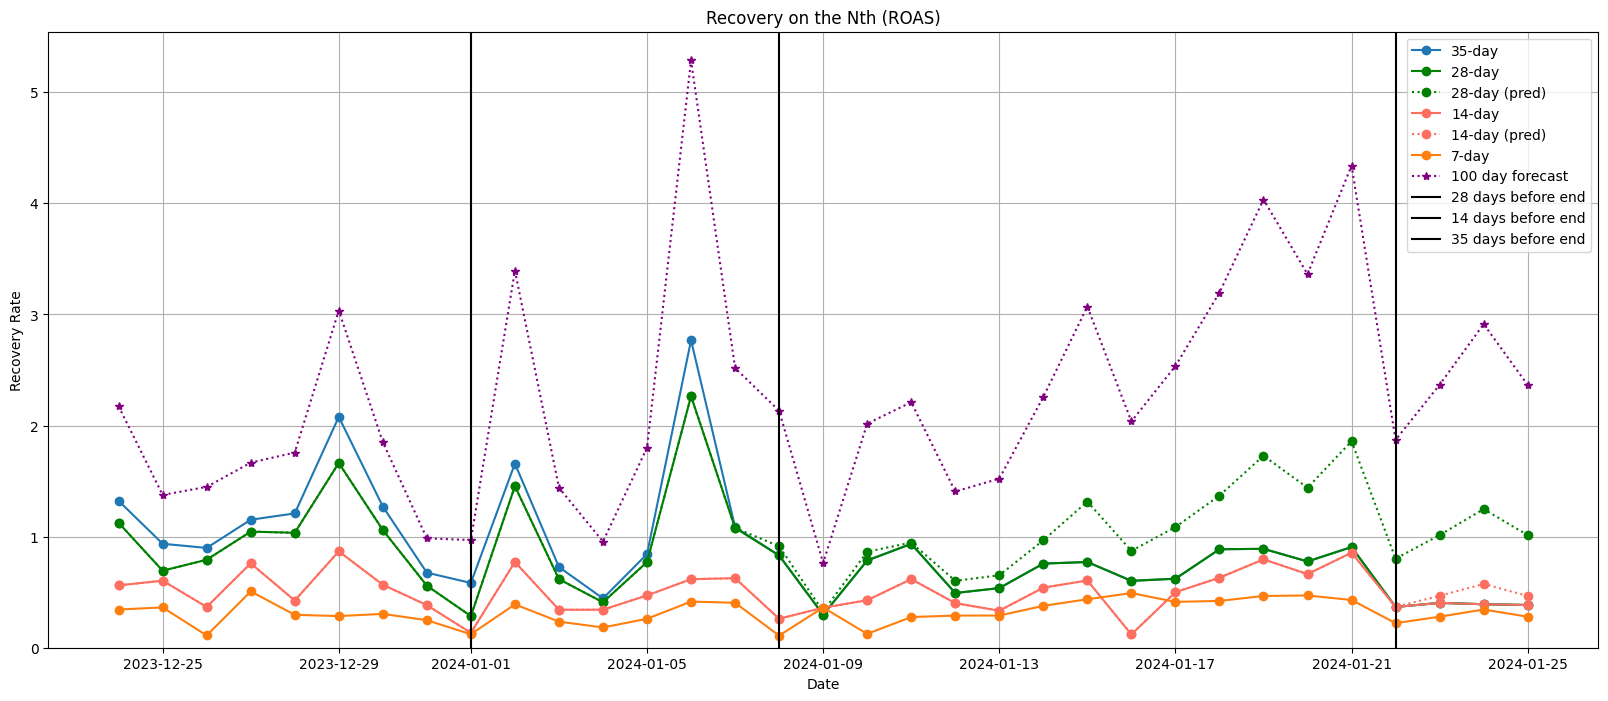

In [132]:
plt.figure(figsize=(20, 8))
from datetime import datetime
# Plotting the data
a = bi_report_pred[bi_report_pred['date_dt'] > '2023-12-01'][bi_report_pred['date_dt'] <= '2024-01-25']
plt.plot(a['date_dt'], a['recycle_worths_35day_rate'], marker='o', label='35-day')
plt.plot(a['date_dt'], a['recycle_worths_28day_rate'], marker='o', label='28-day', color = 'green')
plt.plot(a['date_dt'], a['day28_prediction'], marker='o', label='28-day (pred)', linestyle='dotted', color = 'green')
plt.plot(a['date_dt'], a['recycle_worths_14day_rate'], marker='o', label='14-day', color = '#FF6F61')
plt.plot(a['date_dt'], a['day14_prediction'], marker='o', label='14-day (pred)', linestyle='dotted', color='#FF6F61')  # Coralle Orange
plt.plot(a['date_dt'], a['recycle_worths_7day_rate'], marker='o', label='7-day')

# Plotting the 100-day forecast with a solid line
plt.plot(a['date_dt'], a['day100_prediction'], marker='*', label='100 day forecast', color = '#800080', linestyle='dotted')

# Set y-axis limit to start from 0
plt.ylim(bottom=0)

# Add vertical lines with solid black color
current_date = datetime.now().date()
target_date = current_date - timedelta(days=27)
plt.axvline(target_date, color='black', linestyle='-', label='28 days before end')

current_date = datetime.now().date()
target_date = current_date - timedelta(days=13)
plt.axvline(target_date, color='black', linestyle='-', label='14 days before end')

current_date = datetime.now().date()
target_date = current_date - timedelta(days=34)
plt.axvline(target_date, color='black', linestyle='-', label='35 days before end')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Recovery Rate')
plt.title('Recovery on the Nth (ROAS)')
plt.legend()

plt.grid(True)
plt.show()

